 # **<u> Projet SIGMA M2 : TELEA** </u> 

### **Importation des bibliothèques nécessaire au projet**

In [52]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import geopandas as gpd
import sys
import numpy as np
import pandas as pd
sys.path.insert(0, "/home/onyxia/work/")
from my_function import rasterisation
from libsigma import read_and_write as rw
from libsigma.read_and_write import load_img_as_array
from libsigma.read_and_write import write_image 
from libsigma.read_and_write import open_image
from libsigma import classification as cla
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from libsigma import plots
from sklearn.metrics import confusion_matrix, classification_report

### **Importation des chemins d'accès**

In [ ]:
ts_path = '/home/onyxia/work/data/projet_eval'
result_path = '/home/onyxia/work/projet_telea_MARTIN_AXEL/results/'
in_vector = os.path.join(ts_path, "PI_strates_pyrenees_32630.shp")
ref_image = os.path.join(ts_path, "pyrenees_23-24_B02.tif")
out_classif = '/home/onyxia/work/results/carte_strates.tif'


### **Importation des échantillons disponibles de la zone d'étude / Analyse des échantillons disponibles** 

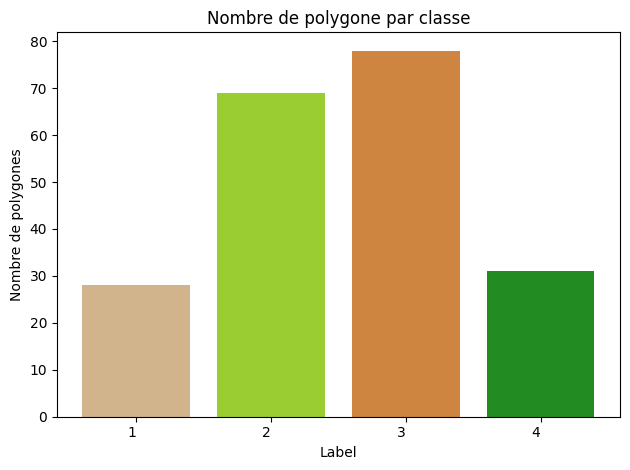

gdal_rasterize -at -a strate -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/projet_telea_MARTIN_AXEL/results/samples_raster.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.
Comptage des pixels par classe :
Valeur 1 -> 132 pixels
Valeur 2 -> 313 pixels
Valeur 3 -> 364 pixels
Valeur 4 -> 141 pixels


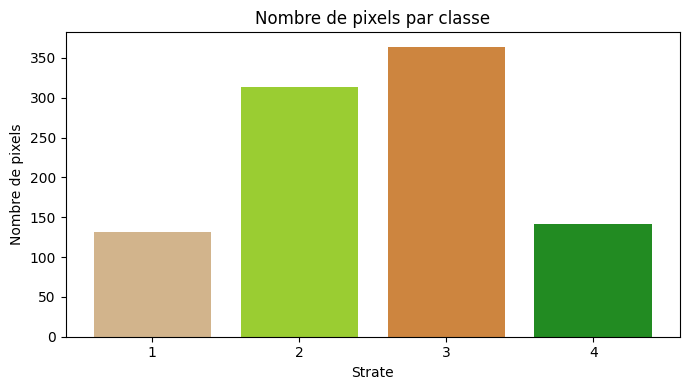

In [ ]:
sample_data = gpd.read_file(in_vector)
sample_data.head
counts_label = sample_data.groupby("strate").size()


strat = "strate"
samples_raster = '/home/onyxia/work/results/samples_raster.tif'


colors = ["tan","yellowgreen", "peru", "forestgreen"]
plt.bar(counts_label.index.astype(str), counts_label.values, color=colors)
plt.title("Nombre de polygone par classe")
plt.xticks(ha="right")
plt.xlabel("Label")
plt.ylabel("Nombre de polygones")
plt.tight_layout()
plt.show()

rasterisation(in_vector, ref_image, samples_raster, strat, dtype="Int32")

arr3d = load_img_as_array(samples_raster, verbose=False)

arr = arr3d[:, :, 0]                                      # on prend la bande 1

# enlever le fond (0)
vals = arr[arr != 0]

values, counts = np.unique(vals, return_counts=True)

print("Comptage des pixels par classe :")
for v, c in zip(values, counts):
    print(f"Valeur {int(v)} -> {int(c)} pixels")

# --- 4) Barplot pixels par classe ---
plt.figure(figsize=(7,4))
plt.bar(values.astype(int).astype(str), counts, color=colors[:len(values)])
plt.title("Nombre de pixels par classe")
plt.xlabel("Strate")
plt.ylabel("Nombre de pixels")
plt.tight_layout()
plt.show()

### **Phénologie des strates, mise en évidence des landes (création du raster)**

In [ ]:
import os
data_type_match = {'uint8': gdal.GDT_Byte,
                   'uint16': gdal.GDT_UInt16,
                   'uint32': gdal.GDT_UInt32,
                   'int16': gdal.GDT_Int16,
                   'int32': gdal.GDT_Int32,
                   'float32': gdal.GDT_Float32,
                   'float64': gdal.GDT_Float64}

# define parameters
dirname = '/home/onyxia/work/data/projet_eval'
out_dirname = '/home/onyxia/work/results'
dir_B3 = os.path.join(dirname, 'pyrenees_23-24_B03.tif')
dir_B5 =  os.path.join(dirname, 'pyrenees_23-24_B05.tif')
out_ari_filename = os.path.join(out_dirname, 'ARI_serie_temp.tif')

# load data
data_set_B3 = open_image(dir_B3)
img_B3 = load_img_as_array(dir_B3)
data_set_B5 = open_image(dir_B5)
img_B5 = load_img_as_array(dir_B5)

# do some processingwith numpy: compute ndvi
B3 = img_B3[:,:,:].astype('float32')
B5 = img_B5[:,:,:].astype('float32')
ari = (1/B3)-(1/B5) / (1/B3)+(1/B5)

# write it
write_image(out_ari_filename, ari, data_set=data_set_B5,
            gdal_dtype=data_type_match['float32'], projection=None)

ds = gdal.Open(out_ari_filename, gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)  
band.FlushCache()
ds = None

## **Création du graphique**

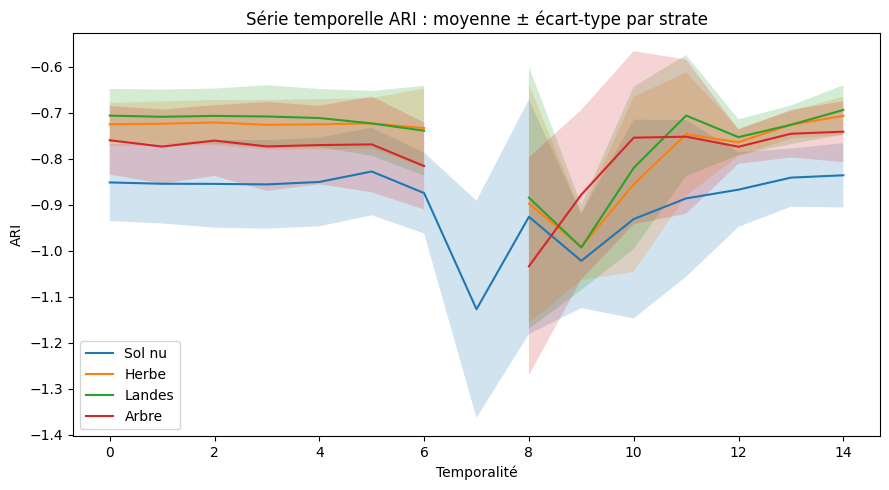

In [56]:

# Extraction des pixels ARI par strate (ROI raster)
dict_X, dict_Y, dict_t = cla.get_samples_from_roi(
    out_ari_filename,       # ton ARI multi-bandes (15 temporalités)
    samples_raster,         # raster des strates (1..4)
    output_fmt="by_label"
)

names = {1:"Sol nu", 2:"Herbe", 3:"Landes", 4:"Arbre"}

fig, ax = plt.subplots(figsize=(9, 5))

# axe x = temporalités (0..14)
n_dates = dict_X[list(dict_X.keys())[0]].shape[1]
x = np.arange(n_dates)

for lab in sorted(dict_X.keys()):   # lab = 1,2,3,4
    X = dict_X[lab]                 # (nb_pixels_de_la_strate, nb_dates)
    mean = X.mean(axis=0)
    std  = X.std(axis=0)

    ax.plot(x, mean, label=names.get(lab, f"Strate {lab}"))
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

ax.set_xlabel("Temporalité")
ax.set_ylabel("ARI")
ax.set_title("Série temporelle ARI : moyenne ± écart-type par strate")
ax.legend()
plt.tight_layout()
plt.show()


### **Production d’une carte de strates à l’échelle du pixel (Stratégie de validation)** ###

In [57]:
X, Y, t = cla.get_samples_from_roi(ref_image, samples_raster)

# split samples
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Définition du modèle et de la grille d'hyperparamètres

rf = RF(random_state=0)

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],    # nombre d'arbres
    "max_depth": [None, 10, 15, 20],        # profondeur maximale des arbres (None = arbre entièrement développé)
    "max_features": [None,"sqrt", "log2"],  # nombre de variables testées à chaque split (valeurs plus faibles → plus les arbres sont différents → meilleure diversité)
    "min_samples_leaf": [1, 5],     # nombre minimal d’échantillons dans une feuille (valeurs plus grandes → arbres plus simples → moins d’overfitting)
    }

# Cross-validation stratifiée (conserve proportion des classes)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
)

# Entraînement avec recherche des meilleurs hyperparamètres 
grid.fit(X_train, Y_train)

print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score moyen CV
print(f"Score CV moyen : {grid.best_score_:.2f}")

# Modèle final (entraîné sur tout le train) 
best_model = grid.best_estimator_

# Evaluation sur le test
Y_pred = best_model.predict(X_test)
acc_test = accuracy_score(Y_test, Y_pred)

print(f"Accuracy test : {acc_test:.2f}")


/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/python/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example

Meilleurs hyperparamètres trouvés :
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Score CV moyen : 0.87
Accuracy test : 0.92


Accuracy test : 0.92


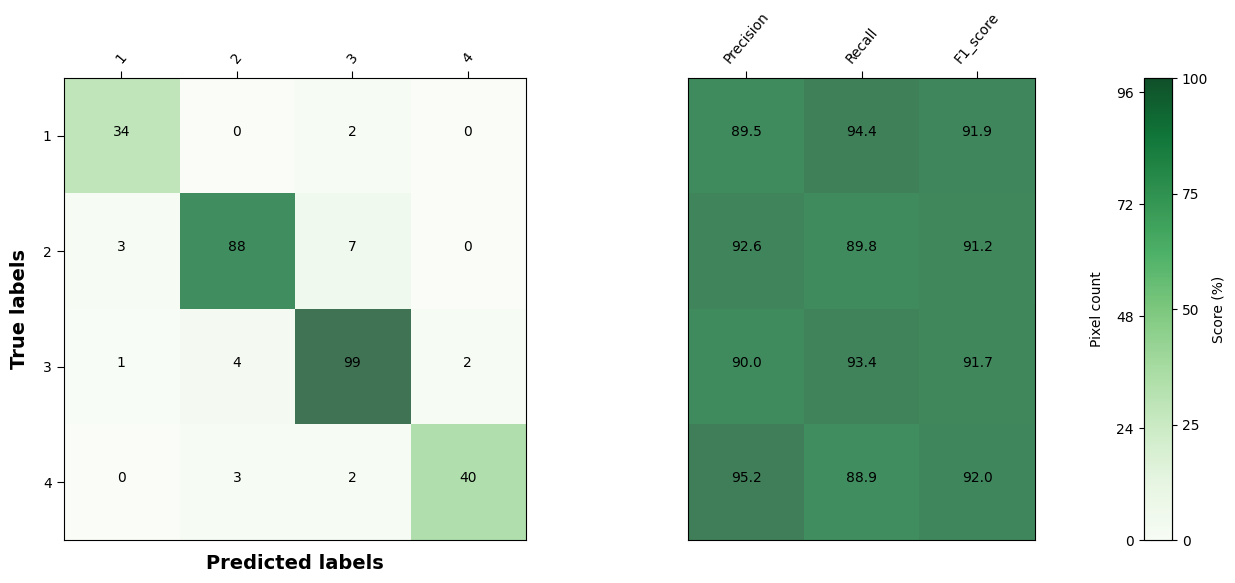

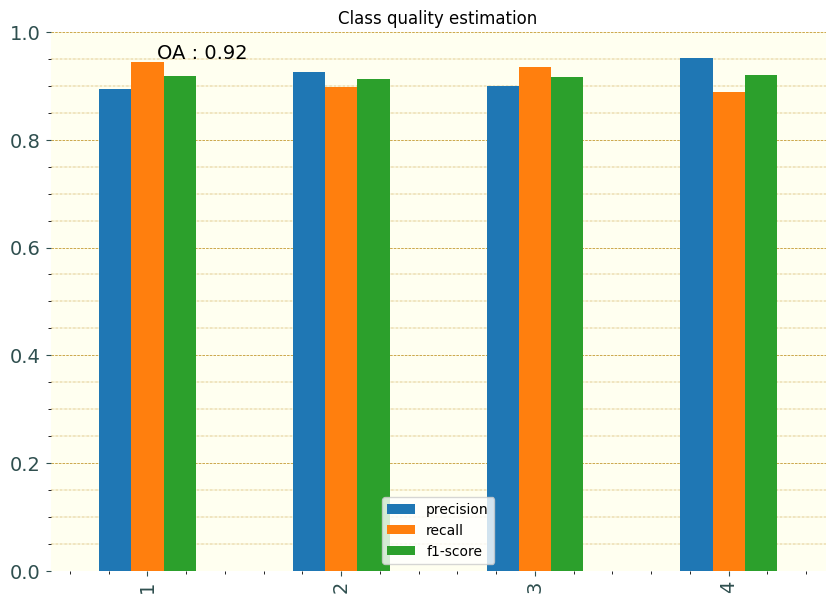

In [58]:
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(Y_test, y_pred)

cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred, labels=np.unique(Y_test),
output_dict=True)

print(f"Accuracy test : {acc_test:.2f}")

# display and save quality
plots.plot_cm(cm, np.unique(Y_test))
plots.plot_class_quality(report, acc_test)

importance des variables 

,Variable,Importance
0,25/09/2023,0.110112
1,30/09/2023,0.040237
2,05/10/2023,0.037752
3,07/10/2023,0.021088
4,10/10/2023,0.030478
5,12/10/2023,0.026989
6,19/11/2023,0.062206
7,16/12/2023,0.095807
8,25/01/2024,0.060188
9,13/03/2024,0.183014


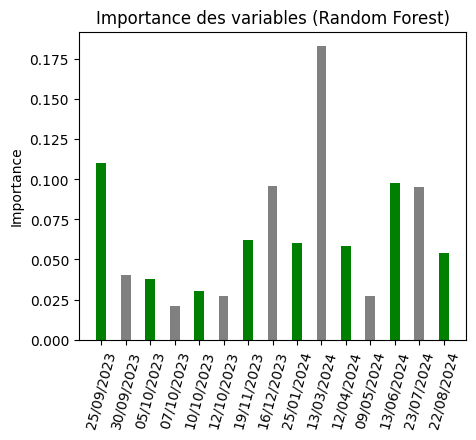

In [59]:
# Importance des variables
importances = best_model.feature_importances_
feature_names = [
    "25/09/2023",
    "30/09/2023",
    "05/10/2023",
    "07/10/2023",
    "10/10/2023",
    "12/10/2023",
    "19/11/2023",
    "16/12/2023",
    "25/01/2024",
    "13/03/2024",
    "12/04/2024",
    "09/05/2024",
    "13/06/2024",
    "23/07/2024",
    "22/08/2024"
]


# DataFrame pour affichage tabulaire
df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
})
display(df_imp)

# Barplot des importances
plt.figure(figsize=(5, 4))
plt.bar(feature_names, importances, color=["green", "gray"], width=0.4)
plt.title("Importance des variables (Random Forest)")
plt.ylabel("Importance")
plt.xticks(rotation=75)
plt.show()

In [63]:
# 5 --- apply on the whole image
# load image


X_img, _, t_img = cla.get_samples_from_roi(ref_image, ref_image)

Y_predict = best_model.predict(X_img)

# reshape
ds = rw.open_image(ref_image)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

img = np.zeros((nb_row, nb_col, 1), dtype='uint8')
img[t_img[0], t_img[1], 0] = Y_predict

# write image
ds = rw.open_image(ref_image)
print("out_classif =", out_classif)
rw.write_image(out_classif, img, data_set=ds, gdal_dtype=data_type_match['uint8'],
            transform=None, projection=None, driver_name=None,
            nb_col=None, nb_ligne=None, nb_band=1)
band = ds.GetRasterBand(1)
band.SetNoDataValue(0)  
band.FlushCache()
ds = None         

/home/onyxia/work/libsigma/classification.py:101: RuntimeWarning: invalid value encountered in cast
  Y = ROI[t].reshape((t[0].shape[0], 1)).astype('int32')


out_classif = /home/onyxia/work/projet_telea_MARTIN_AXEL/results/carte_strates.tif
